<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
# !pip uninstall PIL -y
# !pip uninstall Pillow -y
# !pip install Pillow
# !pip install --Pillow

In [2]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision import datasets, transforms
import skimage
from skimage import io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
import random
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [3]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs = fetch_dataset()

images not found, donwloading...


--2022-12-17 08:38:43--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

     0K .......... .......... .......... .......... ..........  0%  713K 2m29s
    50K .......... .......... .......... .......... ..........  0% 1.39M 1m52s
   100K .......... .......... .......... .......... ..........  0% 66.3M 75s
   150K .......... .......... .......... .......... ..........  0% 72.3M 56s
   200K .......... .......... .......... .......... ..........  0% 1.43M 60s
   250K .......... .......... .......... .......... ..........  0% 87.5M 50s
   300K .......... .......... .......... .......... ..........  0% 59.8M 43s
   350K .......... .......... .......... .......... ..........  0%  196M 38s
   400K .......... .....

extracting...
lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw-deepfunneled/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw-deepfunneled/Abba_Eban/Abba_Eban_0001.jpg
lfw-deepfunneled/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw-deepfunneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw-deepfunneled/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw-deepfunneled

--2022-12-17 08:38:49--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2022-12-17 08:38:49--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

     0K .......... .......... .......... .......... ..........  0% 1.34M 11s
    50K .......... .......... .......... .......... ..........  0% 2.72M 8s
   100K .......... .......... .......... .......... ..........  1% 66.1M 5s
   150K .......... .......... .......... .

done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [5]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

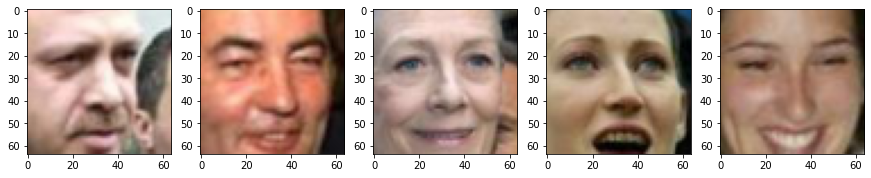

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    ax[i].imshow(train_data[i])


In [7]:
data_train = torch.from_numpy(train_data)
data_test = torch.from_numpy(test_data)

In [8]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=32)
val_loader = torch.utils.data.DataLoader(data_test, batch_size=32)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [9]:
from copy import deepcopy
dim_code = 20
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=12288, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=dim_code)
        )
        self.decoder = nn.Sequential(
                nn.Linear(in_features=dim_code, out_features=512),
                nn.ReLU(),
                nn.Linear(in_features=512, out_features=12288)
            )
    def get_sample(self, latent_code):
        return self.decoder(latent_code)
    def get_vector(self, x):
        x = self.flatten(x).float()
        latent_code = self.encoder(x)
        return latent_code
    def forward(self, x):
        x = self.flatten(x).float()
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction

In [10]:

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

criterion =  F.mse_loss

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

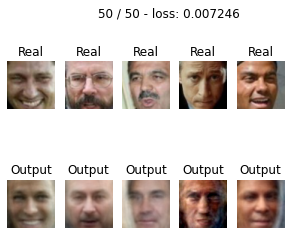

100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


In [11]:
n_epochs = 50
train_losses = []
val_losses = []
check = [random.randint(0, 1000) for _ in range(5)]
for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(torch.float).to(device)
        reconstruction = autoencoder(batch)
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(reconstruction, batch)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
            reconstruction = autoencoder(batch.to(device))
            reconstruction = reconstruction.view(-1, 64, 64, 3)
            loss = criterion(reconstruction, batch.to(device))
            val_losses_per_epoch.append(loss.item())
    clear_output(wait=True)
    for k, idx in enumerate(check):
        plt.subplot(2, 6, k+1)
        plt.imshow(data_test[idx])
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(autoencoder(data_test[None, idx].to(device)).view(64, 64, 3).cpu().detach().numpy())
        plt.title('Output')
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, np.mean(val_losses_per_epoch)))
    plt.show()

    val_losses.append(np.mean(val_losses_per_epoch))

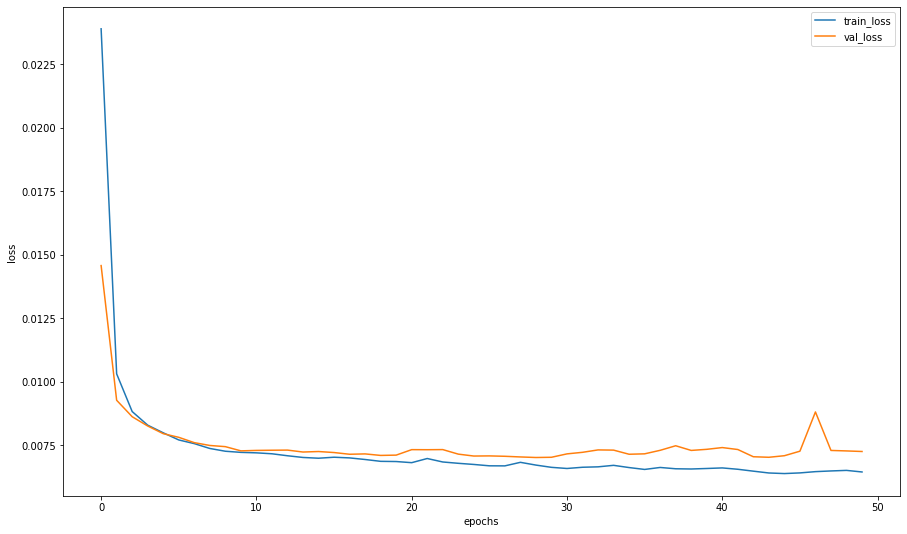

In [12]:
plt.figure(figsize=(15, 9))
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

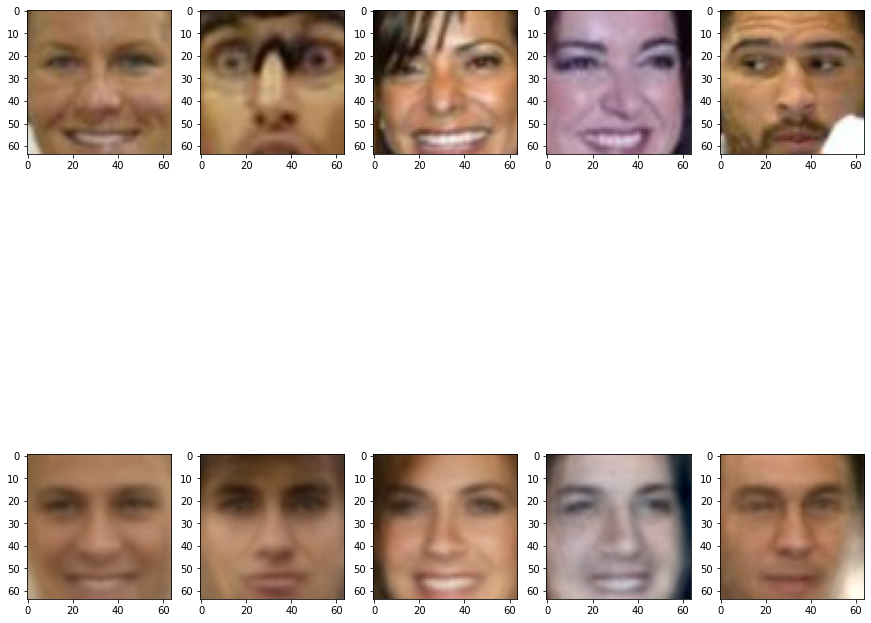

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(15, 15))
for i in range(5):
  ax[0, i].imshow(data_test[i])
  ax[1, i].imshow(autoencoder(data_test[None, i].to(device))[0].view(64, 64, 3).cpu().detach().numpy())

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

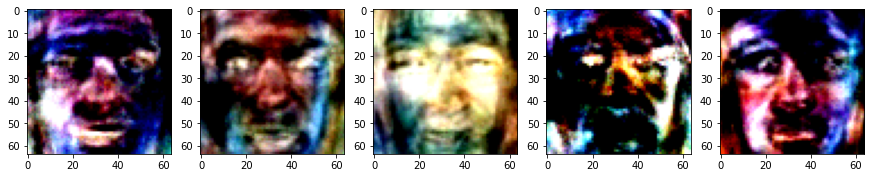

In [14]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code)
z = torch.from_numpy(z).to(device).to(torch.float)
output = autoencoder.get_sample(z).view(25, 64, 64, 3)
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    ax[i].imshow(output[i].cpu().detach().numpy())

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [15]:
smiling_idx = attrs['Smiling'].sort_values(ascending=False)[:15].keys()
sad_idx = attrs['Smiling'].sort_values(ascending=True)[:15].keys()

In [16]:
smiling_data = torch.from_numpy(data[smiling_idx]).to(device)
sad_data = torch.from_numpy(data[sad_idx]).to(device)

In [17]:
smiling_vector = autoencoder.get_vector(smiling_data)
sad_vector = autoencoder.get_vector(sad_data)

In [18]:
smile_mean = (smiling_vector - sad_vector).mean(axis=0)

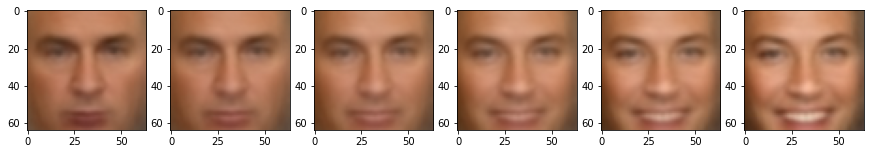

In [19]:
fig, ax = plt.subplots(1, 6, figsize=(15, 15))
for i in range(6):
  ax[i].imshow(autoencoder.get_sample((autoencoder.get_vector(sad_data[None, 6].to(device)) + 0.2 * i * smile_mean)).view(64,64,3).cpu().detach().cpu())

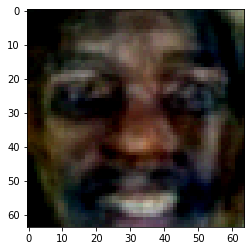

In [20]:
plt.imshow(autoencoder.get_sample(smile_mean).view(64,64,3).cpu().detach().cpu())

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [21]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [22]:
features = 16
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.flatten = nn.Flatten()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=12544, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=features*2)


        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=12544),
            nn.ReLU(),
            nn.Unflatten(1, (16, 28, 28)),
            nn.ConvTranspose2d(16, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=1, padding=2)

        )


    def encode(self, x):
        x = self.encoder(x).view(x.shape[0], 2, -1)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space          
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction, mu, logsigma

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [23]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu ** 2 - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')

    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return log_likelihood(x, reconstruction) + KL_divergence(mu, logsigma)

И обучим модель:

In [24]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

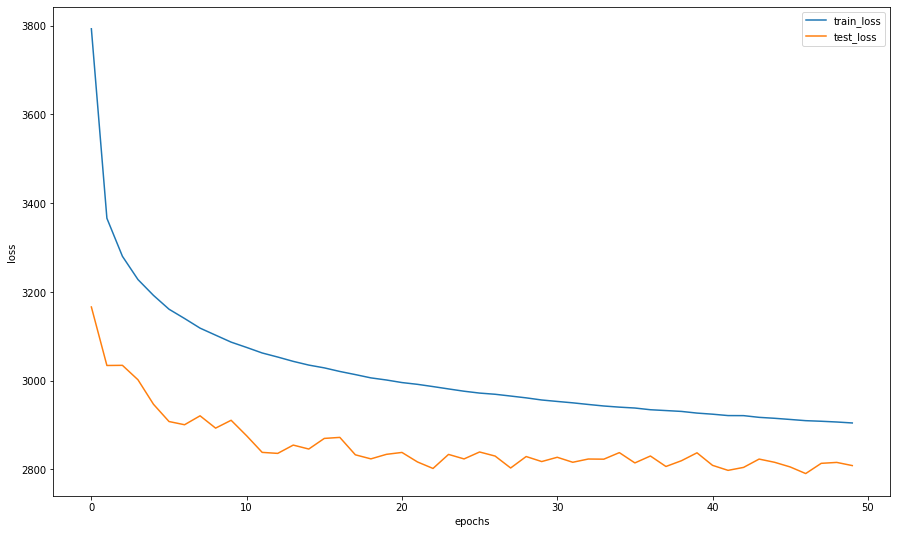

100%|██████████| 50/50 [18:25<00:00, 22.10s/it]


In [25]:
n_epochs = 50
train_losses = []
test_losses = []
mus = torch.Tensor()
labels = torch.Tensor()
for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch, label in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    test_losses_per_epoch = []
    with torch.no_grad():
        for batch, label in test_loader:
            reconstruction, mu, logsigma = autoencoder(batch.to(device))
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
            test_losses_per_epoch.append(loss.item())

    test_losses.append(np.mean(test_losses_per_epoch))

    # Visualize tools
    clear_output(wait=True)

    plt.figure(figsize=(15, 9))
    plt.plot(train_losses, label="train_loss")
    plt.plot(test_losses, label="test_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

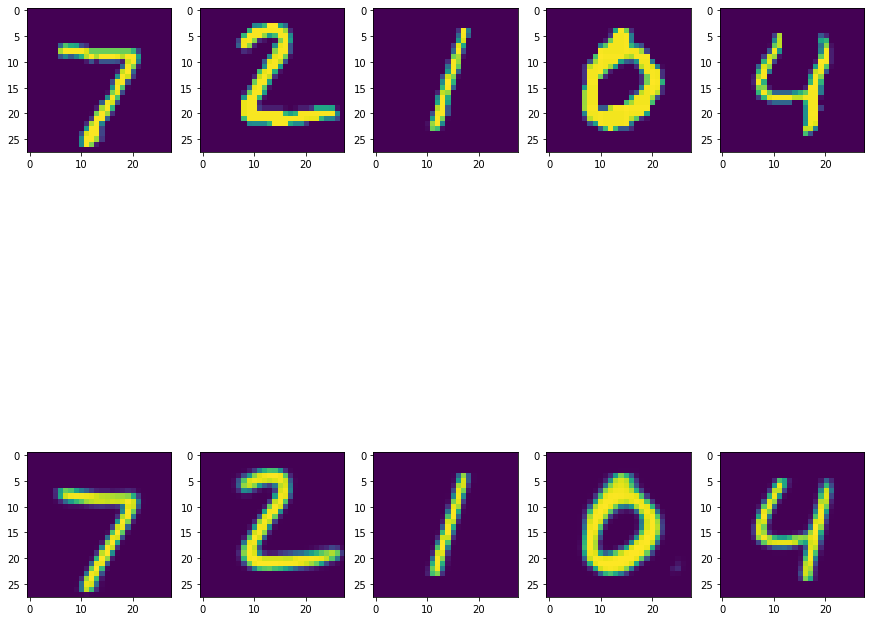

In [26]:
fig, ax = plt.subplots(2, 5, figsize=(15, 15))
for i in range(5):
    ax[0, i].imshow(test_dataset[i][0].view(28,28))
    ax[1, i].imshow(autoencoder(test_dataset[i][0][None].to(device))[0].cpu().detach().numpy().reshape(28, 28))

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

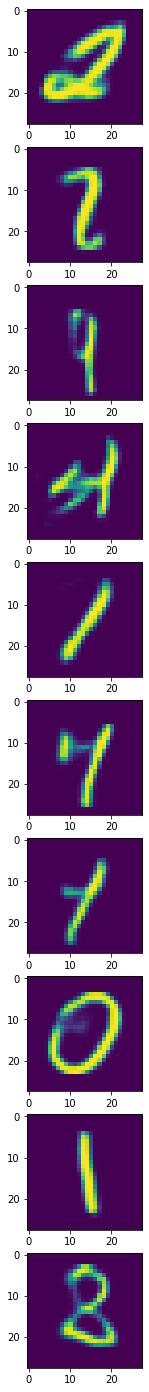

In [27]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 16) for i in range(10)])
z[0][None].shape
fig, ax = plt.subplots(10, figsize=(25, 25))
for i in range(10):
    ax[i].imshow(autoencoder.decode(torch.from_numpy(z[i][None]).float().to(device)).cpu().detach().numpy().reshape(28, 28))


## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [28]:
vectors = np.array([[1, 4]])
np.concatenate((vectors, [[4,3]]), axis=0)
autoencoder.eval()
with torch.no_grad():
    vectors = autoencoder.gaussian_sampler(*autoencoder.encode(test_dataset.data.reshape(10000, 1, 28, 28).to(torch.float).to(device))).cpu().detach().numpy()

In [29]:
from sklearn.manifold import TSNE
vectors_emb = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(vectors)

In [30]:
from sklearn.manifold import TSNE
vectors_emb = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(vectors)
emb_with_label = torch.cat((torch.from_numpy(vectors_emb), test_dataset.targets.view(-1, 1)), dim = 1)


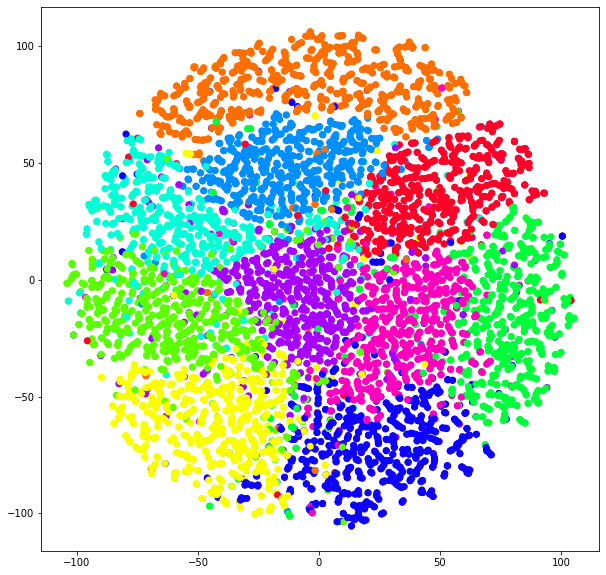

In [31]:
plt.figure(figsize=(10, 10))
plt.scatter(emb_with_label[:, 0], emb_with_label[:, 1], c=emb_with_label[:, 2], cmap='gist_rainbow')

Что вы думаете о виде латентного представления?

Судя по картинке, у нас получилось добиться стандартного нормального распределения

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [32]:
features = 16
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.flatten2 = nn.Flatten(start_dim=2)
        self.ohencod =  OneHotEncoder(handle_unknown='ignore')
        self.ohencod.fit([[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]])
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=12704, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=features*2)


        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=features + 10, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=12544),
            nn.ReLU(),
            nn.Unflatten(1,(16,784)),
            nn.ConvTranspose1d(16, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 1, kernel_size=5, stride=1, padding=2),
            nn.Unflatten(2, (28, 28))

        )

    def encode(self, x, class_num):
        x = self.flatten2(x)
        class_enc = torch.from_numpy(self.ohencod.transform(class_num.view(-1,1)).toarray()).to(device)
        x = torch.cat([x, class_enc[:, None]], 2).to(torch.float).to(device)
        x = self.encoder(x).view(x.shape[0], 2, -1)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space          
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):
        class_enc = torch.from_numpy(self.ohencod.transform(class_num.view(-1,1)).toarray()).to(device)
        z = torch.cat([z, class_enc], 1).to(torch.float).to(device)
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma, class_n = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [33]:
criterion = loss_vae

autoencoder = CVAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

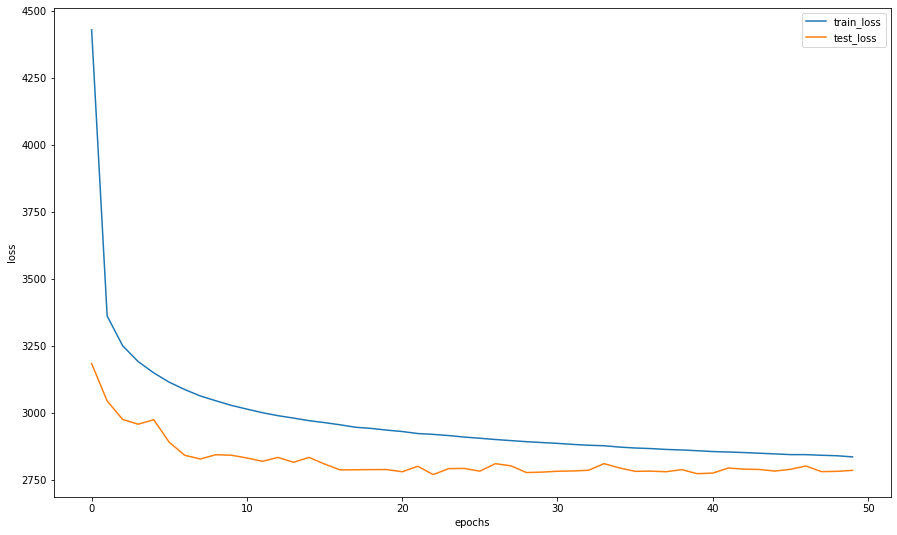

100%|██████████| 50/50 [18:51<00:00, 22.62s/it]


In [34]:
n_epochs = 50
train_losses = []
test_losses = []
mus = torch.Tensor()
labels = torch.Tensor()
for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch, label in train_loader:
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(batch.to(device), label)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    test_losses_per_epoch = []
    with torch.no_grad():
        for batch, label in test_loader:
            mu, logsigma, reconstruction = autoencoder(batch.to(device), label)
            loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
            test_losses_per_epoch.append(loss.item())

    test_losses.append(np.mean(test_losses_per_epoch))

    # Visualize tools
    clear_output(wait=True)

    plt.figure(figsize=(15, 9))
    plt.plot(train_losses, label="train_loss")
    plt.plot(test_losses, label="test_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

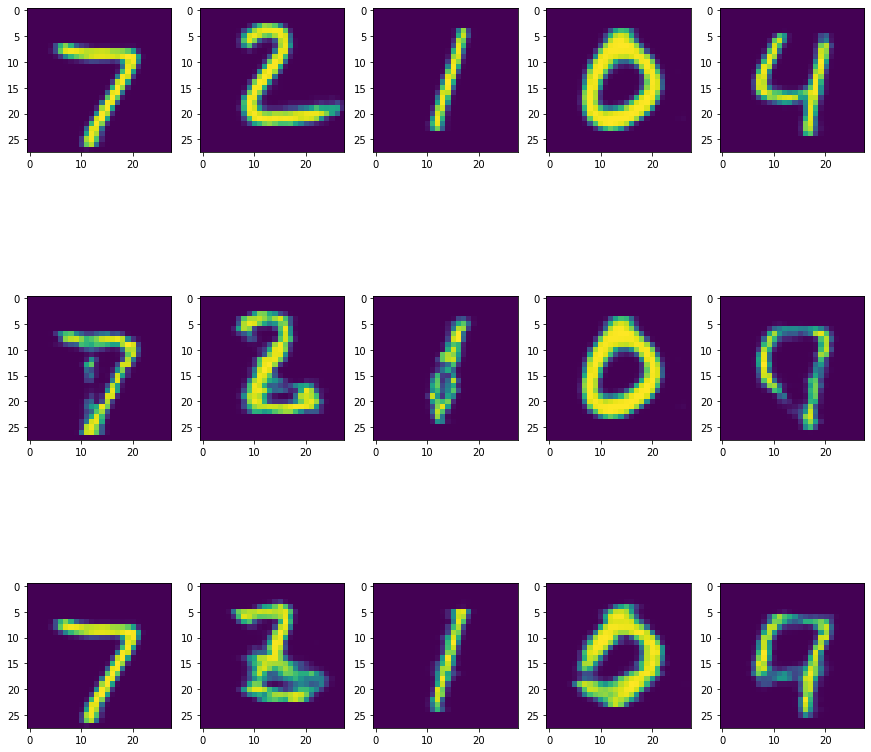

In [35]:
fig, ax = plt.subplots(3, 5, figsize=(15, 15))
for i in range(5):
    ax[0, i].imshow(autoencoder(test_dataset[i][0][None].to(device), torch.tensor(np.array([test_dataset[i][1]])))[2].cpu().detach().numpy().reshape(28, 28))
    ax[1, i].imshow(autoencoder(test_dataset[i][0][None].to(device), torch.tensor(np.array([0])))[2].cpu().detach().numpy().reshape(28, 28))
    ax[2, i].imshow(autoencoder(test_dataset[i][0][None].to(device), torch.tensor(np.array([7])))[2].cpu().detach().numpy().reshape(28, 28))
    
    

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

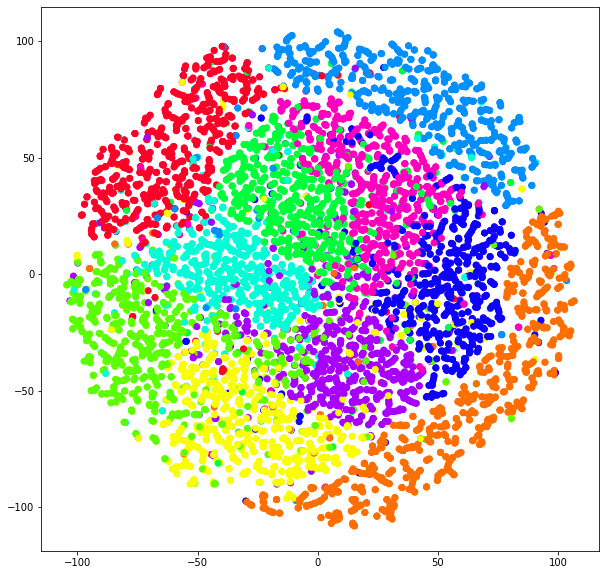

In [36]:

from sklearn.manifold import TSNE
autoencoder.eval()
with torch.no_grad():
    vectors = autoencoder.gaussian_sampler(*autoencoder.encode(test_dataset.data.reshape(10000, 1, 28, 28).to(torch.float).to(device), test_dataset.targets.reshape(-1,1))[:2]).cpu().detach().numpy()
vectors_emb = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(vectors)
emb_with_label = torch.cat((torch.from_numpy(vectors_emb), test_dataset.targets.view(-1, 1)), dim = 1)
plt.figure(figsize=(10, 10))
plt.scatter(emb_with_label[:, 0], emb_with_label[:, 1], c=emb_with_label[:, 2], cmap='gist_rainbow')

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?